<a href="https://colab.research.google.com/github/Pittawas6330210206/bsc_dpdm22/blob/main/midterm_dpdm22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

# 1 ทำนายราคาบ้าน 10 คะแนน
เตรียมข้อมูลเพื่อทำนายราคาบ้าน ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price'``` จากตาราง "คำตอบนักประเมิน(ID)"

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 200,500,1000,2000 เมตร (ตั้งชื่อ d200-7/11','d500-7/11',...,'d2000-7/11' แบะ ;d200-school','d500-school',...,'d2000-school')``` จากตาราง "7-eleven.json" และ "school.json"

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

In [29]:
import pandas as pd
import numpy as np
from pandas.io import json
import geopy.distance

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### นำเข้าข้อมูล

In [31]:
#คำตอบนักประเมิน(ID)
link1 = 'https://docs.google.com/spreadsheets/d/1u9-JTqxFkCzJYPQo-3Dg_GZjfcF_XNDNtf1mtr0dpdI/export?format=xlsx'
detachedhouse = pd.read_excel(link1,sheet_name='บ้าน')

In [32]:
#Data House
link2 = 'https://docs.google.com/spreadsheets/d/1mY0fjGc5OMCsl6qlaGjfTKGVB3ZE2sFg3QDSdxh2nfY/export?format=xlsx'
H1 = pd.read_excel(link2,sheet_name='บ้านมือ1')
H2 = pd.read_excel(link2,sheet_name='บ้านมือ2')


In [33]:
#7-eleven.json
with open('/content/drive/MyDrive/Data Mining/มิดเทอม/7-eleven.json') as json_file:
  seven_eleven = json.loads(json_file.read())

In [34]:
#school.json
with open('/content/drive/MyDrive/Data Mining/มิดเทอม/school.json') as json_file:
  school = json.loads(json_file.read())

In [35]:
detachedhouse

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
3,2.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2400000.0,"ราคาเสนอขายประมาณ 2,200,000 - 2,500,000 บาท/หลัง",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
...,...,...,...,...,...,...,...,...,...,...
1912,2.0,https://nayoo.co/khonkaen/posts/17867,17867.0,บ้านเดี่ยว,มั่นใจ,965000.0,550000.0,"ราคาเสนอขาย 2,000 - 3,000 บาท/ตารางวา",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1913,2.0,https://nayoo.co/khonkaen/posts/17873,17873.0,บ้านเดี่ยว,มั่นใจ,1000000.0,1000000.0,"ราคาเสนอขาย 2,500 - 3,000 บาท/ตารางวา",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1914,2.0,https://nayoo.co/khonkaen/posts/17874,17874.0,บ้านเดี่ยว,มั่นใจ,10873000.0,10000000.0,"ราคาเสนอขาย 12,000 - 15,000 บาท/ตารางวา",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1915,2.0,https://nayoo.co/khonkaen/posts/17876,17876.0,บ้านเดี่ยว,มั่นใจ,1000000.0,1200000.0,ราคาเสนอขาย 1.2-1.5 ล้านบาท/หลัง,NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน


In [36]:
detachedhouse01 = detachedhouse[detachedhouse['ID ผู้ประเมิน']==1]
detachedhouse01

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
6,1.0,https://nayoo.co/khonkaen/posts/564,564.0,บ้านเดี่ยว,มั่นใจ,4400000.0,3500000.0,"5,000-18,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
8,1.0,https://nayoo.co/khonkaen/posts/566,566.0,บ้านเดี่ยว,มั่นใจ,2750000.0,2500000.0,"5,000-25,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
...,...,...,...,...,...,...,...,...,...,...
1862,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1863,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1864,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1865,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


### ข้อมูล Data House

In [37]:
H1

,id,parent_id,project_name,province,district,sub_district,zip_code,zone_id,zone,property_type,...,cable_free,cable_none,cable_ask,position_previous,position_current,sold_out_at,is_pro_in_house,created_at,updated_at,deleted_at
0,314.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
1,315.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านแฝด,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
2,316.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
3,317.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
4,318.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,62204519412ede001495e6cb,622045edc1620300140bc3de,บ้านชีวิตดี (หนองหิน-ศิลา),ขอนแก่น,เมืองขอนแก่น,ศิลา,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,62201e6fa441d30014e1f350,62201f07a441d30014e1f352,เดอะ คาล์ม วิลเลจ,ขอนแก่น,เมืองขอนแก่น,พระลับ,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,5fa0e476a3326800191e29ea,5fa10335d0235b0019c19548,เดอะ เล็ก วิวล์ @พล,ขอนแก่น,พล,โจดหนองแก,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,5e9d6fa69f161600121b61b2,5e9d70379f161600121b61b7,เดอะ เล็ก วิวล์ @แวงน้อย,ขอนแก่น,แวงน้อย,แวงน้อย,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
H2

,id,name_th,name_en,project_name,company,province,district,sub_district,property_type,home improvement,...,furniture,building_number,number_of_building,floor_number,parking_percentage,has_pool,has_keycard,has_security,has_fitness,has_garden
0,1.0,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านวังเวิน,NaN,ขอนแก่น,ชนบท,ศรีบุญเรือง,บ้านเดี่ยว,no,...,ไม่มี,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านหนองบัวบาน,NaN,ขอนแก่น,น้ำพอง,ทรายมูล,บ้านเดี่ยว,no,...,ไม่มี,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,NaN,NaN,ขอนแก่น,มัญจาคีรี,กุดเค้า,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,ชลลดา ขอนแก่น,บริษัท แลนด์แอนด์เฮ้าส์ จำกัด (มหาชน),ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,เบสท์โฮม,เบสท์โฮม เลี่ยงเมืองขอนแก่น,ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,20460P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06026,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06027,NaN,NaN,ขอนแก่น,บ้านฝาง,หนองบัว,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1652,20462P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06033,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06034,NaN,NaN,ขอนแก่น,หนองเรือ,โนนทอง,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1653,20463P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-07581,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-07582,NaN,NaN,ขอนแก่น,แวงน้อย,ก้านเหลือง,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654,20466P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-10402,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-10403,NaN,NaN,ขอนแก่น,ชุมแพ,วังหินลาด,บ้านเดี่ยว,no,...,ไม่ระบุ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### เพิ่ม column second_hand

In [39]:
H1_assign = H1.assign(second_hand='บ้านมือ1') #เพิ่ม column second_handเพื่อแสดงว่า้ป็นบ้านมือ 1หรือบ้านมือ2
H1_assign

,id,parent_id,project_name,province,district,sub_district,zip_code,zone_id,zone,property_type,...,cable_none,cable_ask,position_previous,position_current,sold_out_at,is_pro_in_house,created_at,updated_at,deleted_at,second_hand
0,314.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN,บ้านมือ1
1,315.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านแฝด,...,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN,บ้านมือ1
2,316.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN,บ้านมือ1
3,317.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN,บ้านมือ1
4,318.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,0.0,0.0,NaN,0.0,44012.0,44602.0,NaN,บ้านมือ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,62204519412ede001495e6cb,622045edc1620300140bc3de,บ้านชีวิตดี (หนองหิน-ศิลา),ขอนแก่น,เมืองขอนแก่น,ศิลา,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ1
750,62201e6fa441d30014e1f350,62201f07a441d30014e1f352,เดอะ คาล์ม วิลเลจ,ขอนแก่น,เมืองขอนแก่น,พระลับ,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ1
751,5fa0e476a3326800191e29ea,5fa10335d0235b0019c19548,เดอะ เล็ก วิวล์ @พล,ขอนแก่น,พล,โจดหนองแก,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ1
752,5e9d6fa69f161600121b61b2,5e9d70379f161600121b61b7,เดอะ เล็ก วิวล์ @แวงน้อย,ขอนแก่น,แวงน้อย,แวงน้อย,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ1


In [40]:
H2_assign = H2.assign(second_hand='บ้านมือ2')#เพิ่ม column second_handเพื่อแสดงว่า้ป็นบ้านมือ 1หรือบ้านมือ2
H2_assign

,id,name_th,name_en,project_name,company,province,district,sub_district,property_type,home improvement,...,building_number,number_of_building,floor_number,parking_percentage,has_pool,has_keycard,has_security,has_fitness,has_garden,second_hand
0,1.0,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านเดี่ยว ชนบท ขอนแก่น,บ้านวังเวิน,NaN,ขอนแก่น,ชนบท,ศรีบุญเรือง,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
1,4.0,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านเดี่ยว น้ำพอง ขอนแก่น,บ้านหนองบัวบาน,NaN,ขอนแก่น,น้ำพอง,ทรายมูล,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
2,16.0,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,บ้านเดี่ยว มัญจาคีรี ขอนแก่น,NaN,NaN,ขอนแก่น,มัญจาคีรี,กุดเค้า,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
3,18.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านชลลดา,ชลลดา ขอนแก่น,บริษัท แลนด์แอนด์เฮ้าส์ จำกัด (มหาชน),ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
4,19.0,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,บ้านเดี่ยว เมืองขอนแก่น หมู่บ้านเบสต์โฮม,เบสท์โฮม,เบสท์โฮม เลี่ยงเมืองขอนแก่น,ขอนแก่น,เมืองขอนแก่น,บ้านเป็ด,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,20460P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06026,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06027,NaN,NaN,ขอนแก่น,บ้านฝาง,หนองบัว,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
1652,20462P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06033,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-06034,NaN,NaN,ขอนแก่น,หนองเรือ,โนนทอง,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
1653,20463P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-07581,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-07582,NaN,NaN,ขอนแก่น,แวงน้อย,ก้านเหลือง,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2
1654,20466P,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-10402,ขายถูก! บ้านเดี่ยว จังหวัดขอนแก่น 02-88-10403,NaN,NaN,ขอนแก่น,ชุมแพ,วังหินลาด,บ้านเดี่ยว,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,บ้านมือ2


### รวมข้อมูล DATA HOUSE 

In [41]:
data_house = pd.concat([H1_assign, H2_assign]) ##รวมข้อมูลโดยการconcat
data_house

,id,parent_id,project_name,province,district,sub_district,zip_code,zone_id,zone,property_type,...,land wide(m),land long(m),topsoil,corner,alley,has_pool,has_keycard,has_security,has_fitness,has_garden
0,314.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,315.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านแฝด,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,316.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,317.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,318.0,41.0,ที สเปซ กลางเมือง,ขอนแก่น,เมืองขอนแก่น,เมืองเก่า,NaN,5.0,กลางเมือง-เมืองเก่า-กุดกว้าง,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,20460P,NaN,NaN,ขอนแก่น,บ้านฝาง,หนองบัว,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1652,20462P,NaN,NaN,ขอนแก่น,หนองเรือ,โนนทอง,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1653,20463P,NaN,NaN,ขอนแก่น,แวงน้อย,ก้านเหลือง,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654,20466P,NaN,NaN,ขอนแก่น,ชุมแพ,วังหินลาด,NaN,NaN,NaN,บ้านเดี่ยว,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in data_house.columns: ### เช็คชื่อcolumns
    print(i)


In [88]:
## เลือกเฉพาะcolumnsที่ต้องการ
data_house_use = data_house[['id','renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price','latitude','longitude','second_hand']]
data_house_use

,id,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,second_hand
0,314.0,NaN,NaN,NaN,50.00,2.0,4.0,3.0,0.0,0.0,185.00,2.0,3950000.0,16.392304,102.827926,บ้านมือ1
1,315.0,NaN,NaN,NaN,40.00,2.0,4.0,3.0,0.0,0.0,165.00,2.0,3250000.0,16.392304,102.827926,บ้านมือ1
2,316.0,NaN,NaN,NaN,77.25,2.0,4.0,3.0,0.0,0.0,260.00,2.0,6300000.0,16.392304,102.827926,บ้านมือ1
3,317.0,NaN,NaN,NaN,81.25,2.0,6.0,5.0,0.0,0.0,343.00,3.0,6900000.0,16.392304,102.827926,บ้านมือ1
4,318.0,NaN,NaN,NaN,55.00,2.0,4.0,4.0,0.0,0.0,223.00,2.0,4490000.0,16.392304,102.827926,บ้านมือ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,20460P,no,0.0,0.0,73.00,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,108.76,NaN,437400.0,16.480110,102.574033,บ้านมือ2
1652,20462P,no,0.0,0.0,84.00,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,119.00,NaN,714600.0,16.528551,102.411762,บ้านมือ2
1653,20463P,no,0.0,1.0,45.00,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,188.50,NaN,451000.0,15.867444,102.482085,บ้านมือ2
1654,20466P,no,0.0,1.0,59.00,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,207.00,NaN,910000.0,16.636912,102.105343,บ้านมือ2


### เช็ค missing

In [89]:
data_house_use.isnull().any() ##เช็คค่า missing

id                    False
renovate               True
number_of_rai          True
number_of_ngan         True
number_of_va           True
number_of_story        True
number_of_bedroom      True
number_of_bathroom     True
direction              True
furniture              True
usable_area            True
number_of_parking      True
sell_price             True
latitude               True
longitude              True
second_hand           False
dtype: bool

In [90]:
data_house_use.dtypes #เช็คชนิดข้องข้อมูล

id                     object
renovate               object
number_of_rai         float64
number_of_ngan        float64
number_of_va          float64
number_of_story       float64
number_of_bedroom     float64
number_of_bathroom    float64
direction              object
furniture              object
usable_area           float64
number_of_parking     float64
sell_price            float64
latitude              float64
longitude             float64
second_hand            object
dtype: object

In [46]:
data_house_use['renovate'] = data_house_use['renovate'].fillna('no') #แทนค่าmissing ด้วยnoเนื่องจากข้อมูลที่เป็น missing เป็นข้อมูลของบ้านมือ 1เป็นส่วนมากและบ้านมือ1 น่าจะไม่มีการrenovate
data_house_use['direction'] = data_house_use['direction'].fillna('ไม่ระบุ')#แทนค่าmissing ด้วย ไม่ระบุ เนื่องจากข้อมูลผู้กรอกข้อมูลอาจไม่ทราบหรือไม่ต้องการลงข้อมูล

<ipython-input-46-0dd0b840dc77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_house_use['renovate'] = data_house_use['renovate'].fillna('no')
<ipython-input-46-0dd0b840dc77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_house_use['direction'] = data_house_use['direction'].fillna('ไม่ระบุ')


In [47]:
#แทนค่าmissing ด้วย 0.0 เนื่องจากcolumnsเหล่านี้อาจจะเป็น 0 ก็ได้เช่น number_of_rai บ้าน 1 ไร่มีขนาดกว้างมากเลยคิดว่าnumber_of_raiอาจจะเป็น 0
data_house_use[['number_of_rai', 'number_of_ngan','number_of_va','number_of_parking','number_of_story','number_of_bedroom','number_of_bathroom']]  = data_house_use[['number_of_rai', 'number_of_ngan','number_of_va','number_of_parking','number_of_story','number_of_bedroom','number_of_bathroom']].fillna(0.0)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### DATA HOUSE Final

In [48]:
data_house_use_1 = data_house_use.dropna(subset = ['sell_price','latitude','longitude']) ## ดรอบค่าmissing เนื่องจากข้อมูลเหล่านี้ไม่สามารถประมาณค่าได้เหตุผลมาจากหลายปัจจัยเช่นทำเลที่ตั้ง ราคาที่ในระแวกนั้นๆ
data_house_use_1

,id,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,second_hand
0,314.0,no,0.0,0.0,50.00,2.0,4.0,3.0,0.0,0.0,185.00,2.0,3950000.0,16.392304,102.827926,บ้านมือ1
1,315.0,no,0.0,0.0,40.00,2.0,4.0,3.0,0.0,0.0,165.00,2.0,3250000.0,16.392304,102.827926,บ้านมือ1
2,316.0,no,0.0,0.0,77.25,2.0,4.0,3.0,0.0,0.0,260.00,2.0,6300000.0,16.392304,102.827926,บ้านมือ1
3,317.0,no,0.0,0.0,81.25,2.0,6.0,5.0,0.0,0.0,343.00,3.0,6900000.0,16.392304,102.827926,บ้านมือ1
4,318.0,no,0.0,0.0,55.00,2.0,4.0,4.0,0.0,0.0,223.00,2.0,4490000.0,16.392304,102.827926,บ้านมือ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,20460P,no,0.0,0.0,73.00,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,108.76,0.0,437400.0,16.480110,102.574033,บ้านมือ2
1652,20462P,no,0.0,0.0,84.00,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,119.00,0.0,714600.0,16.528551,102.411762,บ้านมือ2
1653,20463P,no,0.0,1.0,45.00,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,188.50,0.0,451000.0,15.867444,102.482085,บ้านมือ2
1654,20466P,no,0.0,1.0,59.00,2.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,207.00,0.0,910000.0,16.636912,102.105343,บ้านมือ2


In [49]:
data_house_use_1.isnull().any()

id                    False
renovate              False
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story       False
number_of_bedroom     False
number_of_bathroom    False
direction             False
furniture              True
usable_area            True
number_of_parking     False
sell_price            False
latitude              False
longitude             False
second_hand           False
dtype: bool

In [50]:
detachedhouse_merge = detachedhouse.merge(data_house_use_1, left_on='ID', right_on='id') #รวมข้อมูลdetachedhouse_mergeเข้ากับdata_house_use_1
detachedhouse_merge

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์,...,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,second_hand
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,...,2.0,2.0,ไม่ระบุ,ไม่ระบุ,112.0,1.0,2600000.0,16.401504,102.840823,บ้านมือ2
3,2.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2400000.0,"ราคาเสนอขายประมาณ 2,200,000 - 2,500,000 บาท/หลัง",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,...,2.0,2.0,ไม่ระบุ,ไม่ระบุ,112.0,1.0,2600000.0,16.401504,102.840823,บ้านมือ2
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,...,0.0,1.0,ไม่ระบุ,ไม่ระบุ,NaN,0.0,5900000.0,16.413045,102.855357,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,...,3.0,3.0,ไม่ระบุ,ตกแต่งครบ,250.0,1.0,4950000.0,16.539175,102.775903,บ้านมือ2
1902,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,...,3.0,3.0,ไม่ระบุ,ไม่ระบุ,117.0,0.0,3950000.0,16.420415,102.843101,บ้านมือ2
1903,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,...,1.0,1.0,ไม่ระบุ,ไม่ระบุ,844.0,0.0,1700000.0,16.356867,102.743314,บ้านมือ2
1904,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,...,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,155.0,0.0,5900000.0,16.512477,102.951262,บ้านมือ2


In [51]:
detachedhouse_merge.isnull().any()

ID ผู้ประเมิน                     False
post id                           False
ID                                False
property_type                     False
ความมั่นใจในการเมินราคาทรัพย์     False
ราคาทรัพย์                         True
ประเมินราคาซื้อ-ขาย                True
ปัจจัยในการประเมินราคาซื้อ-ขาย     True
เหตุผลไม่มั่นใจราคาประเมิน         True
ให้คะแนนทรัพย์                     True
id                                False
renovate                          False
number_of_rai                     False
number_of_ngan                    False
number_of_va                      False
number_of_story                   False
number_of_bedroom                 False
number_of_bathroom                False
direction                         False
furniture                         False
usable_area                        True
number_of_parking                 False
sell_price                        False
latitude                          False
longitude                         False


In [52]:
for i in detachedhouse_merge.columns:
    print(i)

ID ผู้ประเมิน
post id
ID
property_type
ความมั่นใจในการเมินราคาทรัพย์
ราคาทรัพย์
ประเมินราคาซื้อ-ขาย
ปัจจัยในการประเมินราคาซื้อ-ขาย
เหตุผลไม่มั่นใจราคาประเมิน
ให้คะแนนทรัพย์
id
renovate
number_of_rai
number_of_ngan
number_of_va
number_of_story
number_of_bedroom
number_of_bathroom
direction
furniture
usable_area
number_of_parking
sell_price
latitude
longitude
second_hand


### จำนวนเซเว่นในรัศมี

In [53]:
#7-eleven.json
with open('/content/drive/MyDrive/Data Mining/มิดเทอม/7-eleven.json') as json_file:
  seven_eleven = json.loads(json_file.read())

In [54]:
seven_id = {} #สร้าง list เพื่อเก็บ seven_id
for t in seven_eleven:
    l = list()
    for x in seven_eleven[t]:
        l.append(x['geometry']['location'])
    #print(t)
    #print(l)
    seven_id[t]=l

In [ ]:
seven_id

In [92]:
record_list = []
for id in detachedhouse_merge['ID']:
    try: ##ใช้เพื่อดักจับข้อผิดพลาดที่เกิดขึ้นในระหว่างการแปลงข้อมูล id ให้เป็น int โดยถ้าแปลงไม่ได้ (ValueError) ก็ให้ข้ามขึ้นไปรอบถัดไป โดยขึ้นไปรอบถัดไปแสดงว่า id นั้นไม่สามารถใช้งานได้และจะไม่เกิดการคำนวณระยะห่างใดๆ
        id_int = int(id)
    except ValueError:
        continue

    this_home = detachedhouse_merge[detachedhouse_merge['ID'] == id_int]
    h_lat = this_home['latitude'].values[0]
    h_long = this_home['longitude'].values[0]
    this_seven_eleven_id = seven_id.get(str(id_int), [])#โดยข้อมูลจะถูกดึงจาก "seven_id" ด้วยฟังก์ชัน "get" และส่ง id ของบ้าน
    if not this_seven_eleven_id:                        #โดย "get" จะให้ข้อมูลที่สัมพันธ์กับ id นั้น(หากมีหรือให้ค่าที่กำหนดเป็น default ([]) หากไม่พบข้อมูลสัมพันธ์
        continue #ถ้าไม่มีข้อมูลก็ข้ามไปเลย
    school_dist = [] #คือการสร้างตัวแปรสำหรับเก็บค่าระยะห่างระหว่างบ้านและร้าน Seven Eleven
    loc1 = [h_lat, h_long]
    for seven in this_seven_eleven_id:
        loc2 = [seven['lat'], seven['lng']]
        dist = geopy.distance.geodesic(loc1, loc2).m
        school_dist.append(dist)
    record_dict = {}
    record_dict['id'] = id_int
    record_dict['d200-7/11'] = sum(np.array(school_dist) < 200)
    record_dict['d500-7/11'] = sum(np.array(school_dist) < 500)
    record_dict['d1000-7/11'] = sum(np.array(school_dist) < 1000)
    record_dict['d2000-7/11'] = sum(np.array(school_dist) < 2000)
    record_list.append(record_dict)
final_table_seven = pd.DataFrame(record_list)

### ตารางแสดงจำนวนเซเว่นในรัศมีต่างๆ

In [57]:
final_table_seven

,id,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11
0,25,0,1,1,3
1,25,0,1,1,3
2,33,0,1,3,9
3,33,0,1,3,9
4,495,0,0,2,12
...,...,...,...,...,...
1181,23522,0,0,1,8
1182,23525,0,0,1,8
1183,23533,0,0,0,3
1184,23603,0,2,2,13


### จำนวนโรงเรียนในรัศมี

In [ ]:
#school.json
with open('/content/drive/MyDrive/Data Mining/มิดเทอม/school.json') as json_file:
  school = json.loads(json_file.read())
school

In [59]:
school_id = {}
for t in school:
    l = list()
    for x in school[t]:
        l.append(x['geometry']['location'])
    #print(t)
    #print(l)
    school_id[t]=l

In [ ]:
school_id

In [ ]:
this_school_id = school_id['25']
this_school_id

In [62]:
this_home = detachedhouse_merge[detachedhouse_merge['ID']==25]
this_home    

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์,...,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,second_hand
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2


In [63]:
this_home['latitude'][0]

16.4101787

In [64]:
this_home['longitude'][0]

102.8576126

In [65]:
this_school_id[0]

{'lat': 16.4271467, 'lng': 102.8510554}

In [66]:
this_school_id[0]['lat']

16.4271467

In [67]:
import geopy.distance

In [68]:
loc1 = [this_home['latitude'][0],this_home['longitude'][0]]
loc2 = [this_school_id[0]['lat'],this_school_id[0]['lng']]

In [69]:
geopy.distance.geodesic(loc1,loc2).m

2004.0918545068967

In [70]:
id = 25

In [71]:
this_home25 = detachedhouse_merge[detachedhouse_merge['ID']==25] #เลือกบ้าน
this_home25

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์,...,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,second_hand
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน,...,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,บ้านมือ2


In [72]:
h_lat=this_home['latitude'].values[0]
h_long=this_home['longitude'].values[0] #เลือกตำแหน่งที่ตั้งของบ้าน id 25

In [73]:
this_school_id = school_id[str(id)]

In [74]:
this_school_id

[{'lat': 16.4271467, 'lng': 102.8510554},
 {'lat': 16.4277935, 'lng': 102.87117},
 {'lat': 16.4274974, 'lng': 102.8641133},
 {'lat': 16.3941974, 'lng': 102.8382949},
 {'lat': 16.4209022, 'lng': 102.8492881},
 {'lat': 16.4114947, 'lng': 102.8755964},
 {'lat': 16.4109209, 'lng': 102.8576165},
 {'lat': 16.42569, 'lng': 102.8445007},
 {'lat': 16.4244721, 'lng': 102.8507214},
 {'lat': 16.4053295, 'lng': 102.8370527},
 {'lat': 16.4244972, 'lng': 102.8369393},
 {'lat': 16.4174346, 'lng': 102.8453264},
 {'lat': 16.4257947, 'lng': 102.850832},
 {'lat': 16.4278332, 'lng': 102.8657077}]

In [75]:
school_dist=list() #สร้างฟังก์ชั่นเพื่อแสดงระยะห่างจากบ้านถึงเซเว่น เพื่อนำไปเก็บในlist
lloc1 = [h_lat,h_long]
for school in this_school_id:
    loc2 = [school['lat'],school['lng']]
    dist = geopy.distance.geodesic(loc1,loc2).m
    print(dist)
    school_dist.append(dist)

2004.0918545068967
2428.2987915685653
2038.435849524896
2717.652621461165
1482.8417616510071
1926.415131599258
82.13510412222988
2215.3515258053017
1744.6197787401782
2260.7109855845897
2717.8019980442086
1538.46971795965
1873.7358589714045
2136.4745799527823


In [76]:
record_list = list()

In [77]:
record_dict = {}
record_dict['id'] = int(id)
record_dict['d200-school'] = sum(np.array(school_dist) < 200)
record_dict['d500-school'] = sum(np.array(school_dist) < 500)
record_dict['d1000-school'] = sum(np.array(school_dist) < 1000)
record_dict['d2000-school'] = sum(np.array(school_dist) < 2000)


In [78]:
record_dict

{'id': 25,
 'd200-school': 1,
 'd500-school': 1,
 'd1000-school': 1,
 'd2000-school': 6}

In [79]:
record_list.append(record_dict)

In [80]:
pd.DataFrame(record_list)

,id,d200-school,d500-school,d1000-school,d2000-school
0,25,1,1,1,6


In [81]:
detachedhouse_merge['ID'] 

0         25.0
1         25.0
2         33.0
3         33.0
4        495.0
         ...  
1901    30327P
1902    30328P
1903    30330P
1904    30331P
1905    30332P
Name: ID, Length: 1906, dtype: object

## ระยะห่าง

In [82]:
record_list = []
for id in detachedhouse_merge['ID']:
    try:
        id_int = int(id)
    except ValueError:
        continue

    this_home = detachedhouse_merge[detachedhouse_merge['ID'] == id_int]
    h_lat = this_home['latitude'].values[0]
    h_long = this_home['longitude'].values[0]
    this_school_id = school_id.get(str(id_int), [])
    if not this_school_id:
        continue
    school_dist = []
    loc1 = [h_lat, h_long]
    for school in this_school_id:
        loc2 = [school['lat'], school['lng']]
        dist = geopy.distance.geodesic(loc1, loc2).m
        school_dist.append(dist)
    record_dict = {}
    record_dict['id'] = id_int
    record_dict['d200-school'] = sum(np.array(school_dist) < 200)
    record_dict['d500-school'] = sum(np.array(school_dist) < 500)
    record_dict['d1000-school'] = sum(np.array(school_dist) < 1000)
    record_dict['d2000-school'] = sum(np.array(school_dist) < 2000)
    record_list.append(record_dict)
final_table_school = pd.DataFrame(record_list)


## ตารางแสดงจำนวนโรงเรียนในรัศมีต่างๆ

In [83]:
final_table_school

,id,d200-school,d500-school,d1000-school,d2000-school
0,25,1,1,1,6
1,25,1,1,1,6
2,33,0,0,2,11
3,33,0,0,2,11
4,495,0,1,1,7
...,...,...,...,...,...
1339,23522,0,0,1,5
1340,23525,1,3,4,10
1341,23533,0,0,0,6
1342,23603,1,1,1,8


In [84]:
#school_id['690'] = '0.0'

In [85]:
detachedhouse01

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
4,1.0,https://nayoo.co/khonkaen/posts/495,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
6,1.0,https://nayoo.co/khonkaen/posts/564,564.0,บ้านเดี่ยว,มั่นใจ,4400000.0,3500000.0,"5,000-18,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
8,1.0,https://nayoo.co/khonkaen/posts/566,566.0,บ้านเดี่ยว,มั่นใจ,2750000.0,2500000.0,"5,000-25,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
...,...,...,...,...,...,...,...,...,...,...
1862,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1863,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1864,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1865,1.0,https://www.baania.com/listing/%E0%B8%82%E0%B8...,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,เพื่อป้องกันปัญหาที่อาจเกิดขึ้นภายหลังหากต้องม...,NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


# 2 ทำนายสภาพอากาศ 10 คะแนน
เตรียมข้อมูลเพื่อทำนายสภาพอากาศของวันถัดไป โดย 
- กลุ่มที่ 1 และ 9 ทำนาย อุณหภูมิตุ้มแห้ง (Y)
- กลุ่มที่ 2 ทำนาย อุณหภูมิต่ำสุด (Y)
- กลุ่มที่ 3 ทำนาย อุณหภูมิจุดน้ำค้าง (Y)
- กลุ่มที่ 4 ทำนาย จำนวนเมฆ (Y)
- กลุ่มที่ 5 ทำนาย ปริมาณฝน (Y)
- กลุ่มที่ 6 ทำนาย ความชื้นสัมพัทธ์ (Y)
- กลุ่มที่ 7 ทำนาย ความกด (Y)
- กลุ่มที่ 8 ทำนาย ความเร็วลม (Y)

ลักษณะของ data เป็นดังนี้ Xi คือ features อื่นๆที่ใช้ในทำนาย และ Y คือค่าที่ต้องการทำนาย

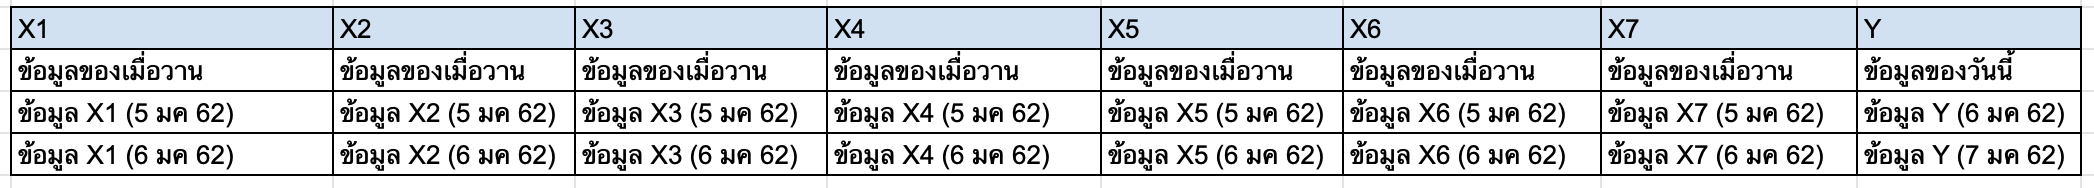



In [102]:
# อุณหภูมิจุดน้ำค้าง
kkd = pd.read_excel('/content/drive/MyDrive/Data Mining/Quiz/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.ขอนแก่น.xlsx',sheet_name=0,skiprows=4)
npd = pd.read_excel('/content/drive/MyDrive/Data Mining/Quiz/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.นครพนม.xlsx',sheet_name=0,skiprows=4)
ld = pd.read_excel('/content/drive/MyDrive/Data Mining/Quiz/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.สกล.xlsx',sheet_name=0,skiprows=4)
skd = pd.read_excel('/content/drive/MyDrive/Data Mining/Quiz/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.สกล.xlsx',sheet_name=0,skiprows=4)
nkd = pd.read_excel('/content/drive/MyDrive/Data Mining/Quiz/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.หนองคาย.xlsx',sheet_name=0,skiprows=4)

In [103]:
kkd.rename(columns = {'Unnamed: 0':'ที่','Unnamed: 1':'สถานี', 'Unnamed: 2':'เดือน/ปี','Unnamed: 34':'เฉลี่ย'}, inplace = True)
npd.rename(columns = {'Unnamed: 0':'ที่','Unnamed: 1':'สถานี', 'Unnamed: 2':'เดือน/ปี','Unnamed: 34':'เฉลี่ย'}, inplace = True)
ld.rename(columns = {'Unnamed: 0':'ที่','Unnamed: 1':'สถานี', 'Unnamed: 2':'เดือน/ปี','Unnamed: 34':'เฉลี่ย'}, inplace = True)
skd.rename(columns = {'Unnamed: 0':'ที่','Unnamed: 1':'สถานี', 'Unnamed: 2':'เดือน/ปี','Unnamed: 34':'เฉลี่ย'}, inplace = True)
nkd.rename(columns = {'Unnamed: 0':'ที่','Unnamed: 1':'สถานี', 'Unnamed: 2':'เดือน/ปี','Unnamed: 34':'เฉลี่ย'}, inplace = True)

In [104]:
Table6 = pd.concat([kkd,npd,ld,skd,nkd])
Table6

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,24.2,24.0,22.9,21.9,21.7,21.3,21.9,...,21.0,21.8,21.8,20.7,20.8,21.9,20.3,19.7,19.7,21.903226
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,20.2,18.5,19.4,19.0,19.2,20.6,21.3,...,18.9,16.7,16.7,18.3,19.2,18.9,19,18.3,-,18.910000
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,17.7,15.3,12.7,14.0,14.6,16.6,19.1,...,15.8,12.9,9.8,9.7,12.4,16.1,16.3,16.1,16.3,14.525806
3,1,381201-ขอนแก่น จ.ขอนแก่น,2012-01-01,16.5,17.4,18.7,17.0,15.3,16.7,15.6,...,21.5,19.2,19.2,16.3,19.5,19.7,19.4,18.7,16.7,18.058065
4,2,381201-ขอนแก่น จ.ขอนแก่น,2012-02-01,18.0,19.6,19.5,19.2,20.7,20.8,19.1,...,18.4,17.0,16.3,18.8,22.3,22.1,21.3,-,-,18.772414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,48,352201-หนองคาย จ.หนองคาย,2021-10-01,24.4,24.7,24.7,23.5,23.2,23.2,23.8,...,20.2,20.2,20.4,20.8,20.9,21.0,22.5,23.3,23.3,22.977419
51,49,352201-หนองคาย จ.หนองคาย,2021-11-01,23.2,22.8,22.3,22.4,22.2,22.5,22.9,...,17.7,16.4,17.8,17.8,16.3,16.1,16.6,14.9,-,19.873333
52,50,352201-หนองคาย จ.หนองคาย,2021-12-01,14.6,13.4,10.7,10.4,10.6,11.2,10.2,...,16.7,18.1,18.0,17.4,16.5,16.6,17.3,17.5,16.3,15.219355
53,1,352201-หนองคาย จ.หนองคาย,2022-01-01,15.9,15.7,16.3,16.5,17.4,17.7,17.2,...,19.4,18.2,16.9,17.5,17.2,16.9,18.3,17.5,17.3,17.219355


In [105]:
Table6.isnull().any()

ที่         False
สถานี       False
เดือน/ปี    False
1           False
2           False
3           False
4           False
5           False
6           False
7           False
8           False
9           False
10          False
11          False
12          False
13          False
14          False
15          False
16          False
17          False
18          False
19          False
20          False
21          False
22          False
23          False
24          False
25          False
26          False
27          False
28          False
29          False
30          False
31          False
เฉลี่ย      False
dtype: bool

In [106]:
kkd['จังหวัด'] = "ขอนแก่น"
KKN06 = kkd.drop(['ที่','เฉลี่ย'],axis=1)
KKN06.set_index(['จังหวัด','สถานี','เดือน/ปี'],inplace=True)
KKN006 = KKN06.stack().reset_index()
KKN006.rename(columns = {'level_3':'วันที่',0:'อุณหภูมิจุดน้ำค้าง'}, inplace = True)
KKN006['เดือน'] = KKN006['เดือน/ปี'].dt.month
KKN006['ปี'] = KKN006['เดือน/ปี'].dt.year
newKKN6 = KKN006[['จังหวัด','สถานี','วันที่','เดือน','ปี','อุณหภูมิจุดน้ำค้าง']]
newKKN6

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7
...,...,...,...,...,...,...
1700,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,27,2,2022,15.7
1701,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,28,2,2022,17.5
1702,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,29,2,2022,-
1703,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,30,2,2022,-


In [107]:
npd['จังหวัด'] = "นครพนม"
NPM06 = npd.drop(['ที่','เฉลี่ย'],axis=1)
NPM06.set_index(['จังหวัด','สถานี','เดือน/ปี'],inplace=True)
NPM006 = NPM06.stack().reset_index()
NPM006.rename(columns = {'level_3':'วันที่',0:'อุณหภูมิจุดน้ำค้าง'}, inplace = True)
NPM006['เดือน'] = NPM006['เดือน/ปี'].dt.month
NPM006['ปี'] = NPM006['เดือน/ปี'].dt.year
newNPM6 = NPM006[['จังหวัด','สถานี','วันที่','เดือน','ปี','อุณหภูมิจุดน้ำค้าง']]
newNPM6
     

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,25.1
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,23.1
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,20.1
3,นครพนม,357201-นครพนม จ.นครพนม,4,10,2011,18.9
4,นครพนม,357201-นครพนม จ.นครพนม,5,10,2011,20.7
...,...,...,...,...,...,...
1700,นครพนม,357201-นครพนม จ.นครพนม,27,2,2022,13.2
1701,นครพนม,357201-นครพนม จ.นครพนม,28,2,2022,14.9
1702,นครพนม,357201-นครพนม จ.นครพนม,29,2,2022,-
1703,นครพนม,357201-นครพนม จ.นครพนม,30,2,2022,-


In [108]:
ld['จังหวัด'] = "เลย"
LEI06 = ld.drop(['ที่','เฉลี่ย'],axis=1)
LEI06.set_index(['จังหวัด','สถานี','เดือน/ปี'],inplace=True)
LEI006 = LEI06.stack().reset_index()
LEI006.rename(columns = {'level_3':'วันที่',0:'อุณหภูมิจุดน้ำค้าง'}, inplace = True)
LEI006['เดือน'] = LEI006['เดือน/ปี'].dt.month
LEI006['ปี'] = LEI006['เดือน/ปี'].dt.year
newLEI6 = LEI006[['จังหวัด','สถานี','วันที่','เดือน','ปี','อุณหภูมิจุดน้ำค้าง']]
newLEI6

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,เลย,356201-สกลนคร จ.สกลนคร,1,10,2011,24.5
1,เลย,356201-สกลนคร จ.สกลนคร,2,10,2011,23.6
2,เลย,356201-สกลนคร จ.สกลนคร,3,10,2011,21.1
3,เลย,356201-สกลนคร จ.สกลนคร,4,10,2011,20.0
4,เลย,356201-สกลนคร จ.สกลนคร,5,10,2011,21.2
...,...,...,...,...,...,...
1700,เลย,356201-สกลนคร จ.สกลนคร,27,2,2022,15.7
1701,เลย,356201-สกลนคร จ.สกลนคร,28,2,2022,17.3
1702,เลย,356201-สกลนคร จ.สกลนคร,29,2,2022,-
1703,เลย,356201-สกลนคร จ.สกลนคร,30,2,2022,-


In [109]:
skd['จังหวัด'] = "สกลนคร"
SNK06 = skd.drop(['ที่','เฉลี่ย'],axis=1)
SNK06.set_index(['จังหวัด','สถานี','เดือน/ปี'],inplace=True)
SNK006 = SNK06.stack().reset_index()
SNK006.rename(columns = {'level_3':'วันที่',0:'อุณหภูมิจุดน้ำค้าง'}, inplace = True)
SNK006['เดือน'] = SNK006['เดือน/ปี'].dt.month
SNK006['ปี'] = SNK006['เดือน/ปี'].dt.year
newSNK6 = SNK006[['จังหวัด','สถานี','วันที่','เดือน','ปี','อุณหภูมิจุดน้ำค้าง']]
newSNK6

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,24.5
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,23.6
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,21.1
3,สกลนคร,356201-สกลนคร จ.สกลนคร,4,10,2011,20.0
4,สกลนคร,356201-สกลนคร จ.สกลนคร,5,10,2011,21.2
...,...,...,...,...,...,...
1700,สกลนคร,356201-สกลนคร จ.สกลนคร,27,2,2022,15.7
1701,สกลนคร,356201-สกลนคร จ.สกลนคร,28,2,2022,17.3
1702,สกลนคร,356201-สกลนคร จ.สกลนคร,29,2,2022,-
1703,สกลนคร,356201-สกลนคร จ.สกลนคร,30,2,2022,-


In [110]:
nkd['จังหวัด'] = "หนองคาย"
NKI06 = nkd.drop(['ที่','เฉลี่ย'],axis=1)
NKI06.set_index(['จังหวัด','สถานี','เดือน/ปี'],inplace=True)
NKI006 = NKI06.stack().reset_index()
NKI006.rename(columns = {'level_3':'วันที่',0:'อุณหภูมิจุดน้ำค้าง'}, inplace = True)
NKI006['เดือน'] = NKI006['เดือน/ปี'].dt.month
NKI006['ปี'] = NKI006['เดือน/ปี'].dt.year
newNKI6 = NKI006[['จังหวัด','สถานี','วันที่','เดือน','ปี','อุณหภูมิจุดน้ำค้าง']]
newNKI6

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,24.6
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,23.8
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,22.4
3,หนองคาย,352201-หนองคาย จ.หนองคาย,4,10,2011,21.9
4,หนองคาย,352201-หนองคาย จ.หนองคาย,5,10,2011,23.3
...,...,...,...,...,...,...
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8
1701,หนองคาย,352201-หนองคาย จ.หนองคาย,28,2,2022,17.8
1702,หนองคาย,352201-หนองคาย จ.หนองคาย,29,2,2022,16.6
1703,หนองคาย,352201-หนองคาย จ.หนองคาย,30,2,2022,14.9


In [111]:
import pandas as pd
import numpy as np
from datetime import datetime 

In [115]:
FinalTable = pd.concat([newKKN6,newNPM6,newLEI6,newSNK6,newNKI6])
FinalTable

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7
...,...,...,...,...,...,...
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8
1701,หนองคาย,352201-หนองคาย จ.หนองคาย,28,2,2022,17.8
1702,หนองคาย,352201-หนองคาย จ.หนองคาย,29,2,2022,16.6
1703,หนองคาย,352201-หนองคาย จ.หนองคาย,30,2,2022,14.9


In [116]:
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง,date
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2,2011-10-01
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0,2011-10-02
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9,2011-10-03
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9,2011-10-04
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7,2011-10-05
...,...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2,2022-02-24
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3,2022-02-25
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2,2022-02-26
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8,2022-02-27


In [117]:
FinalTable.drop('date', axis=1)

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7
...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8


In [118]:
pd.pivot_table(FinalTable, index='สถานี', columns='วันที่', values='อุณหภูมิจุดน้ำค้าง')

วันที่,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
สถานี,,,,,,,,,,,,,,,,,,,,,
352201-หนองคาย จ.หนองคาย,18.881818,18.861818,18.923636,18.738182,18.860000,18.720000,18.934545,18.943636,18.785455,18.685455,...,18.872727,18.676364,18.285455,18.254545,18.329091,18.472727,18.816364,18.565957,18.138636,17.093939
356201-สกลนคร จ.สกลนคร,18.367273,18.254545,18.158182,18.267273,18.420000,18.336364,18.636364,18.445455,18.165455,18.061818,...,18.312727,17.952727,17.660000,17.612727,17.854545,18.092727,18.225455,17.876596,17.443182,16.284848
357201-นครพนม จ.นครพนม,17.758182,17.592727,17.563636,17.665455,17.836364,17.714545,18.143636,17.850909,17.543636,17.340000,...,17.823636,17.385455,17.187273,17.123636,17.281818,17.396364,17.585455,17.244681,16.668182,15.845455
381201-ขอนแก่น จ.ขอนแก่น,18.647273,18.543636,18.281818,18.300000,18.314545,18.487273,18.700000,18.763636,18.696364,18.254545,...,18.241818,18.167273,17.776364,17.730909,17.823636,18.185455,18.285455,18.289362,17.859091,16.878788


In [119]:
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable

<ipython-input-119-9edc5b8edb0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
<ipython-input-119-9edc5b8edb0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')


,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง,date
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2,2011-10-01
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0,2011-10-02
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9,2011-10-03
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9,2011-10-04
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7,2011-10-05
...,...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2,2022-02-24
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3,2022-02-25
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2,2022-02-26
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8,2022-02-27


In [120]:
FinalTable.drop(['วันที่', 'เดือน', 'ปี'], axis=1)

,จังหวัด,สถานี,อุณหภูมิจุดน้ำค้าง,date
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,24.2,2011-10-01
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,24.0,2011-10-02
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,22.9,2011-10-03
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,21.9,2011-10-04
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,21.7,2011-10-05
...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,13.2,2022-02-24
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,14.3,2022-02-25
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,15.2,2022-02-26
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,15.8,2022-02-27


In [121]:
FinalTable.info()
     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8320 entries, 0 to 1701
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   จังหวัด             8320 non-null   object        
 1   สถานี               8320 non-null   object        
 2   วันที่              8320 non-null   int64         
 3   เดือน               8320 non-null   int64         
 4   ปี                  8320 non-null   int64         
 5   อุณหภูมิจุดน้ำค้าง  8320 non-null   object        
 6   date                8320 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 520.0+ KB


In [122]:
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable
     

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง,date
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2,2011-10-01
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0,2011-10-02
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9,2011-10-03
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9,2011-10-04
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7,2011-10-05
...,...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2,2022-02-24
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3,2022-02-25
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2,2022-02-26
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8,2022-02-27


In [123]:
FinalTable1 = FinalTable.drop('date', axis=1)
FinalTable1

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7
...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8


In [124]:
FinalTable1_transpose = np.transpose(FinalTable1)
FinalTable1_transpose

,0,1,2,3,4,5,6,7,8,9,...,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701
จังหวัด,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,ขอนแก่น,...,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย,หนองคาย
สถานี,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,...,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย,352201-หนองคาย จ.หนองคาย
วันที่,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
เดือน,10,10,10,10,10,10,10,10,10,10,...,2,2,2,2,2,2,2,2,2,2
ปี,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022
อุณหภูมิจุดน้ำค้าง,24.2,24.0,22.9,21.9,21.7,21.3,21.9,23.3,23.4,22.7,...,23.2,16.4,13.3,14.7,14.1,13.2,14.3,15.2,15.8,17.8


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3639 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s

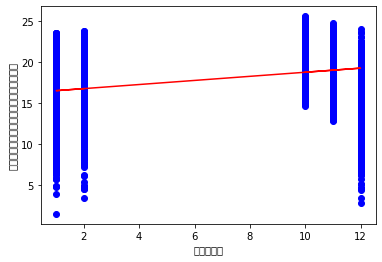

Temperature in month 6: [17.77473347]


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ดึงข้อมูลอุณหภูมิ
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable

# แบ่งข้อมูลเป็น feature และ target
X = FinalTable["เดือน"].values.reshape(-1, 1)
y = FinalTable["อุณหภูมิจุดน้ำค้าง"].values

# สร้างโมเดล Linear Regression
reg = LinearRegression().fit(X, y)

# วาดกราฟที่แสดงผลลัพธ์
plt.scatter(X, y, color="blue")
plt.plot(X, reg.predict(X), color="red")
plt.xlabel("เดือน")
plt.ylabel("อุณหภูมิจุดน้ำค้าง")
plt.show()

# ทำนายอุณหภูมิในเดือนที่ 6
print("Temperature in month 6:", reg.predict(np.array([[6]])))

In [126]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# ดึงข้อมูลอุณหภูมิ
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable

# แบ่งข้อมูลเป็น feature และ target
X = FinalTable["เดือน"].values.reshape(-1, 1)
y = FinalTable["อุณหภูมิจุดน้ำค้าง"].values

# สร้างโมเดล Linear Regression
reg = LinearRegression().fit(X, y)

# ทำนายอุณหภูมิในเดือนที่ 6
print("Temperature in month 6:", reg.predict(np.array([[6]])))
print("Temperature in month 7:", reg.predict(np.array([[7]])))

Temperature in month 6: [17.77473347]
Temperature in month 7: [18.02433248]


In [127]:
arr1 = [[1, 2, 3], [4, 5, 6]]

arr1_transpose = np.transpose(arr1)

In [128]:
arr1_transpose

array([[1, 4],
       [2, 5],
       [3, 6]])

In [129]:
import pandas as pd

# สร้างตารางเดิม
cols=["ปี","เดือน","วันที่"]
FinalTable['date'] = FinalTable[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
FinalTable['date'] = pd.to_datetime(FinalTable['date'], errors='coerce')
FinalTable = FinalTable.dropna(subset=['date'])
FinalTable

# สร้างตารางทำนาย
def predict_temperature(temp):
  return temp + 10

FinalTable["อุณหภูมิ_ทำนาย"] = FinalTable["อุณหภูมิจุดน้ำค้าง"].apply(predict_temperature)

print(FinalTable)


      จังหวัด                     สถานี  วันที่  เดือน    ปี  \
0     ขอนแก่น  381201-ขอนแก่น จ.ขอนแก่น       1     10  2011   
1     ขอนแก่น  381201-ขอนแก่น จ.ขอนแก่น       2     10  2011   
2     ขอนแก่น  381201-ขอนแก่น จ.ขอนแก่น       3     10  2011   
3     ขอนแก่น  381201-ขอนแก่น จ.ขอนแก่น       4     10  2011   
4     ขอนแก่น  381201-ขอนแก่น จ.ขอนแก่น       5     10  2011   
...       ...                       ...     ...    ...   ...   
1697  หนองคาย  352201-หนองคาย จ.หนองคาย      24      2  2022   
1698  หนองคาย  352201-หนองคาย จ.หนองคาย      25      2  2022   
1699  หนองคาย  352201-หนองคาย จ.หนองคาย      26      2  2022   
1700  หนองคาย  352201-หนองคาย จ.หนองคาย      27      2  2022   
1701  หนองคาย  352201-หนองคาย จ.หนองคาย      28      2  2022   

     อุณหภูมิจุดน้ำค้าง       date  อุณหภูมิ_ทำนาย  
0                  24.2 2011-10-01            34.2  
1                  24.0 2011-10-02            34.0  
2                  22.9 2011-10-03            32.9  
3                  

In [130]:
FinalTable

,จังหวัด,สถานี,วันที่,เดือน,ปี,อุณหภูมิจุดน้ำค้าง,date,อุณหภูมิ_ทำนาย
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2,2011-10-01,34.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0,2011-10-02,34.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9,2011-10-03,32.9
3,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,4,10,2011,21.9,2011-10-04,31.9
4,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,5,10,2011,21.7,2011-10-05,31.7
...,...,...,...,...,...,...,...,...
1697,หนองคาย,352201-หนองคาย จ.หนองคาย,24,2,2022,13.2,2022-02-24,23.2
1698,หนองคาย,352201-หนองคาย จ.หนองคาย,25,2,2022,14.3,2022-02-25,24.3
1699,หนองคาย,352201-หนองคาย จ.หนองคาย,26,2,2022,15.2,2022-02-26,25.2
1700,หนองคาย,352201-หนองคาย จ.หนองคาย,27,2,2022,15.8,2022-02-27,25.8
